# Setup

In [1]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
%pip install -U "tensorflow==2.10.0"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install remotezip tqdm opencv-python
%pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections
import seaborn as sns

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

import shutil #roba fresca aggiunta da poco
import matplotlib.pyplot as plt

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

# Fase di Pre-Processing

Definire la funzione `get_class` che recupera il nome della classe da un nome di file. Quindi, creare una funzione chiamata `get_files_per_class` che converte l'elenco di tutti i file (file sopra) in un dizionario che elenca i file per ogni classe:

In [4]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-7]

In [5]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Esegui il seguente codice per stampare il numero totale di video che hai tra tutte le sottocartelle del dataset.

In [6]:
download_dir = pathlib.Path("C:/Users/Vincenzo/Desktop/Materiale_Gruppo_24/Lips_video_10_seconds_division_train_test_val/")

video_count_train = len(list(download_dir.glob('Train/*/*.avi')))
video_count_val = len(list(download_dir.glob('Validation/*/*.avi')))
video_count_test = len(list(download_dir.glob('Test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test

print(f"print_train: {video_count_train}")
print(f"print_val: {video_count_val}")
print(f"print_test: {video_count_test}")
print(f"Total videos: {video_total}")

print_train: 960
print_val: 160
print_test: 160
Total videos: 1280


# Crea fotogrammi da ogni file video

La funzione `frames_from_video_file` divide i video in frame, legge un intervallo scelto a caso di `n_frames` da un file video e li restituisce come array NumPy. Per ridurre la memoria e il sovraccarico di calcolo, scegliere un **piccolo** numero di fotogrammi. Inoltre, scegli lo stesso numero di fotogrammi da ogni video, il che rende più facile lavorare su lotti di dati.


In [7]:
def frames_from_video_file(video_path, n_frames, output_size=(90, 60), frame_step=3):
    """
    Creates frames from each video file present for each category.

    Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

    Return:
        A NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    def format_frames(frame, output_size):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, output_size)
        return frame[:, :, np.newaxis]

    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)

    return result

# Visualizza dati video

Snippet di codice per fare un gif dato un video preso a caso nella cartella di Train


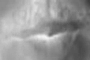

In [8]:
def to_gif(images):
    converted_images = np.squeeze(images)  # Rimuovi la dimensione del canale (1) se presente
    converted_images = np.clip(converted_images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=125)
    return embed.embed_file('./animation.gif')

# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(download_dir.glob('Train/*/*.avi')), 40)
to_gif(ucf_sample_video)

Successivamente, definire la classe `FrameGenerator` per creare un oggetto iterabile in grado di immettere dati nella pipeline di dati TensorFlow. La funzione generatore (`__call__`) produce l'array di frame prodotto da `frames_from_video_file` e un vettore codificato one-hot dell'etichetta associata all'insieme di frame.

In [9]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

## Configurazione sul dataset per le perfomance

Utilizzare il prefetching con buffer in modo da poter produrre dati dal disco senza che l'I/O diventi un blocco. Due funzioni importanti da utilizzare durante il caricamento dei dati sono:

* `Dataset.cache`: mantiene i set di frame in memoria dopo che sono stati caricati dal disco durante la prima epoca. Questa funzione assicura che il set di dati non diventi un collo di bottiglia durante l'addestramento del modello. Se il tuo set di dati è troppo grande per entrare in memoria, puoi anche usare questo metodo per creare una cache su disco performante.

* `Dataset.prefetch`: sovrappone la preelaborazione dei dati e l'esecuzione del modello durante l'addestramento.

Per preparare i dati da immessi nel modello, utilizzare il batching come mostrato di seguito. Si noti che quando si lavora con dati video, come i file AVI, i dati dovrebbero essere modellati come un oggetto a cinque dimensioni. Queste dimensioni sono le seguenti:`[batch_size, number_of_frames, height, width, channels]`. In confronto, un'immagine avrebbe quattro dimensioni:`[batch_size, height, width, channels]`. L'immagine qui sotto è un'illustrazione di come viene rappresentata la forma dei dati video.

![Video data shape](https://www.tensorflow.org/images/tutorials/video/video_data_shape.png)

In [10]:
n_frames = 40
batch_size = 32

output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_path = pathlib.Path("C:/Users/Vincenzo/Desktop/Materiale_Gruppo_24/Lips_video_10_seconds_division_train_test_val/Train")
test_path = pathlib.Path("C:/Users/Vincenzo/Desktop/Materiale_Gruppo_24/Lips_video_10_seconds_division_train_test_val/Test")
val_path = pathlib.Path("C:/Users/Vincenzo/Desktop/Materiale_Gruppo_24/Lips_video_10_seconds_division_train_test_val/Validation")


train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, n_frames, training=True),
                                          output_signature = output_signature)
# Batch the data
train_ds = train_ds.batch(batch_size)


val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path, n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, n_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

## Definire la rete

Ora che hai creato un TensorFlow `Dataset` di fotogrammi video con le loro etichette, puoi usarlo con un modello di apprendimento profondo. Il seguente modello di classificazione che utilizza un modello  [EfficientNet](https://arxiv.org/abs/1905.11946){:.external}  pre-addestrato:

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

# Definizione del modello
model = tf.keras.Sequential([
    #tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(8),
    tf.keras.layers.GlobalAveragePooling3D(),
])


## Carico il modello


In [12]:
# Restore the weights
model.load_weights('C:/Users/Vincenzo/Desktop/Materiale_Gruppo_24/Sperimentazioni_Reti_2D/2dcnn_100_epoche_BIANCO_NERO/Pesi_Modello/pesi_2dcnn_100_epoche_BIANCO_NERO')

model.compile(optimizer = optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

# Evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Modello caricato: accuracy: {:5.2f}%".format(100 * acc))

5/5 - 24s - loss: 1.7633 - accuracy: 0.2875 - 24s/epoch - 5s/step
Modello caricato: accuracy: 28.75%


# Valutare il modello

In [13]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [14]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of babele for ' + ds_type)
  ax.set_xlabel('Predicted Language')
  ax.set_ylabel('Actual Language')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [15]:
fg = FrameGenerator(train_path, n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

# Rename the labels based on the provided mapping
label_mapping = {
    1: 'Italian',
    2: 'English',
    3: 'German',
    4: 'Spanish',
    5: 'Dutch',
    6: 'Russian',
    7: 'Japanese',
    8: 'French'
}

labels = [int(label) for label in labels]

renamed_labels = [label_mapping[label_id] for label_id in labels]

# Print the renamed labels
print(renamed_labels)


['Italian', 'English', 'German', 'Spanish', 'Dutch', 'Russian', 'Japanese', 'French']


5/5 [==============================] - 19s 3s/step


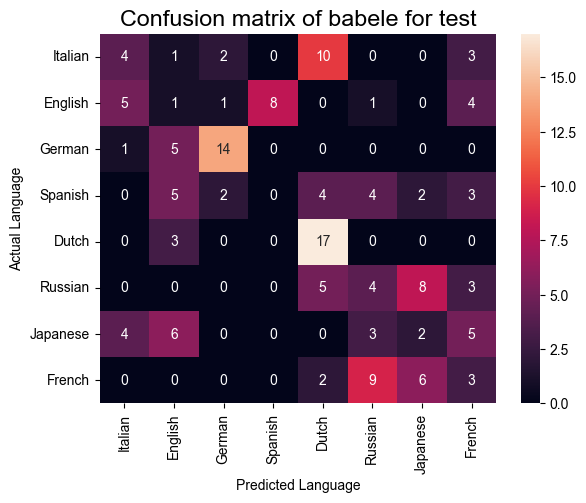

In [16]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, renamed_labels, 'test')

I valori di precision e recall per ogni classe possono anche essere calcolati utilizzando una matrice di confusione.

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, renamed_labels) # Test dataset

In [ ]:
precision

In [ ]:
recall